In [4]:
using Mimi
using OptiMimi
include("../../src/lib/readconfig.jl")
include("../../src/lib/datastore.jl")

dncload (generic function with 1 method)

In [5]:
config = readconfig("../../configs/standard-60year-colorado.yml");
suffix = getsuffix()

"-08"

In [6]:
include("../../src/optimization_COGW.jl")

Loading from saved region network...


  likely near /Users/jrising/.julia/v0.4/Graphs/src/common.jl:3
  likely near /Users/jrising/.julia/v0.4/Graphs/src/dot.jl:80


Loading from saved water network...
Loading from saved region network...
Loading from saved region network...
Loading from saved region network...


Use convert(Array, da).
 in depwarn at deprecated.jl:73
 in array at /Users/jrising/.julia/v0.4/DataArrays/src/deprecated.jl:23
 in include at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_from_node1 at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_from_node1 at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_from_node1 at /Applications/Julia-0.4.0.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_string at loading.jl:266
 in execute_request at /Users/jrising/.julia/v0.4/IJulia/src/execute_request.jl:164
 in eventloop at /Users/jrising/.julia/v0.4/IJulia/src/IJulia.jl:138
 in anonymous at task.jl:447
while loading /Users/jrising/research/water/model/awash/src/watercostdata.jl, in

Creating model...
agriculture/edds/barley-gdd.csv
agriculture/edds/barley-kdd.csv
agriculture/edds/sorghum-gdd.csv
agriculture/edds/sorghum-kdd.csv
agriculture/edds/soybeans-gdd.csv
agriculture/edds/soybeans-kdd.csv
agriculture/edds/hay-gdd.csv
agriculture/edds/otherhay-gdd.csv
agriculture/edds/hay-kdd.csv
agriculture/edds/otherhay-kdd.csv
Objectives...
Constraints...
Missing reservoir.1894
1
3
668
672
675
2
4
5
6
7
8
9
755
756
744
745
898
759
10
11
12
14
15
13
16
17
18
19
20
22
23
21
25
26
24
27
28
29
754
31
32
33
34
35
30
739
740
737
738
36
38
37
735
40
41
42
43
736
44
39
45
47
48
49
50
51
46
52
56
57
58
59
60
62
61
63
64
65
730
731
732
66
53
54
55
727
68
69
67
70
76
78
722
79
715
723
77
712
714
713
80
82
83
710
711
706
707
72
73
81
84
74
75
71
635
636
85
86
87
88
678
680
683
679
676
677
89
681
696
682
90
91
92
93
94
95
96
97
98
99
100
101
102
666
654
644
103
662
663
641
643
647
656
661
642
104
648
655
649
659
660
645
646
105
664
667
665
673
674
106
702
726
684
685
107
650
651
930
10

In [7]:
using MathProgBase
@time sol = linprog(-house.f, house.A, '<', house.b, house.lowers, house.uppers)

  1.781631 seconds (1.26 M allocations: 45.977 MB, 3.98% gc time)


MathProgBase.HighLevelInterface.LinprogSolution(:Optimal,-1.4603151610927874e8,[0.0,2378.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],Dict{Any,Any}(:redcost=>[23.8744,0.0,90.0008,12.1091,44.9666,2.9956,3.048e5,11.4081,46.6923,3.048e5  …  74.8892,124.733,105.016,93.6918,90.7723,125.136,116.064,27.0725,102.272,29.8694],:lambda=>[-123.556,-119.864,-1352.9,-112.985,-206.044,-122.066,-124.991,-118.24,-45.8665,-92.3675  …  0.0,0.0,0.0,0.0,-1231.45,0.0,0.0,-1303.17,-1228.21,-628.409]))

In [8]:
using RCall

In [10]:
parlens = varlengths(m, house.paramcomps, house.parameters)
varlens = varlengths(m, house.constcomps, house.constraints)

waternetdata = load(datapath("waternet/waternet.RData"));
netdata = waternetdata["network"]
netdata[:uid] = ["$(netdata[row, :collection]).$(netdata[row, :colid])" for row in 1:nrow(netdata)]
constvalues = house.A * sol.sol;

In [11]:
df = DataFrame(lon=Float64[], lat=Float64[], nextlon=Float64[], nextlat=Float64[], outflow=Float64[]) #inflow=Float64[], withdraw=Float64[])
for ii in 1:length(downstreamorder)
    latlon = netdata[netdata[:uid] .== downstreamorder[ii].label, :]
    if isna(latlon[:nextpt][1])
        nextlatlon = latlon
    else
        nextlatlon = netdata[latlon[:nextpt], :]
    end
    outflow = constvalues[varlens[1] + ii]
    push!(df, [latlon[:lon][1], latlon[:lat][1], nextlatlon[:lon][1], nextlatlon[:lat][1], outflow])
end

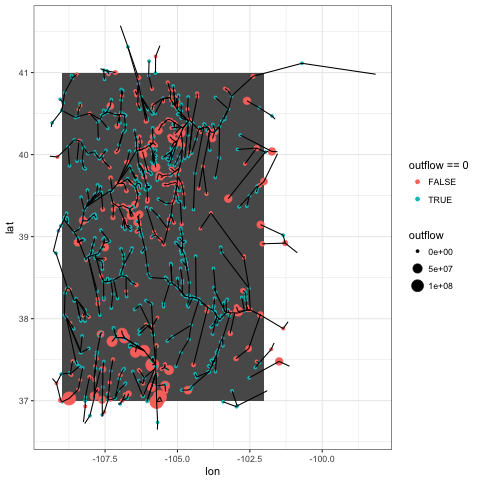

RCall.RObject{RCall.VecSxp}


In [12]:
R"library(ggplot2)"
R"ggplot($df, aes(lon, lat)) + geom_rect(aes(xmin=-109, xmax=-102, ymin=37, ymax=41)) +
geom_point(aes(size=outflow, colour=outflow==0)) + geom_segment(aes(xend=nextlon, yend=nextlat)) + theme_bw()"

In [26]:
recorded = readtable(datapath("extraction/USGS-2010.csv"))
recorded[:value] = recorded[:IR_SW] * config["timestep"] * 1383. / 12
RECORDED = sum(recorded[recorded[:STATE] .== "CO", :value])

1.164212166e7

In [24]:
RUNOFF = sum(addeds)

3.669494763034407e8

In [22]:
SW = sum(sol.sol[64:(961+63)])

3.4308454754321533e8

In [23]:
GW = sum(sol.sol[1:63])

148365.20838047995

In [32]:
data = reshape(sol.sol[sum(parlens[1:2])+1:sum(parlens[1:3])], 63, 8)
result = DataFrame()
for cc in 1:length(unicrops)
    result[symbol(unicrops[cc])] = data[:, cc]
end
result

,barley,corn.co.rainfed,corn.co.irrigated,sorghum,soybeans,wheat.co.rainfed,wheat.co.irrigated,hay
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,549.158902,0.0,0.0,14458.216722,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,10706.372816,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,4341.066722,0.0
9,0.0,0.0,0.0,7678.107478,0.0,34258.61913192463,52504.03583807537,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
sum(data, 1)

1x8 Array{Float64,2}:
 0.0  0.0  0.0  20206.8  0.0  3.09022e5  8.93757e5  61624.6